In [1]:
import pandas as pd
import os
import sys
import tqdm
import glob
import h5py
import json
import numpy as np
import pickle
import oyaml as yaml

In [2]:
import csv
import datetime
import gzip

import pprint


import keras
from keras.layers import Input, Dense, TimeDistributed, GlobalAveragePooling1D
from keras.models import Model
from keras import regularizers
from keras.optimizers import Adam
import keras.backend as K
from autopool import AutoPool1D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


Using TensorFlow backend.


In [5]:
def construct_mlp_mil(num_frames, emb_size, num_classes, sensor_factor=True,
                      num_sensors=None, proximity_factor=True, num_proximity_classes=None,
                      hidden_layer_size=128, num_hidden_layers=0, l2_reg=1e-5):
    """
    Construct a 2-hidden-layer MLP model for MIL processing
    Parameters
    ----------
    num_frames
    emb_size
    num_classes
    hidden_layer_size
    num_hidden_layers
    l2_reg
    Returns
    -------
    model
    """
    # Input layer
    inp = Input(shape=(num_frames, emb_size), dtype='float32', name='input')
    y = inp

    # Add hidden layers
    repr_size = emb_size
    for idx in range(num_hidden_layers):
        y = TimeDistributed(Dense(hidden_layer_size, activation='relu',
                                  kernel_regularizer=regularizers.l2(l2_reg)),
                            name='dense_{}'.format(idx+1),
                            input_shape=(num_frames, repr_size))(y)
        repr_size = hidden_layer_size

    if sensor_factor:
        assert num_sensors is not None

        y_sensor_t = TimeDistributed(Dense(num_sensors, activation='softmax',
                                           kernel_regularizer=regularizers.l2(l2_reg)),
                                     name='sensor_t',
                                     input_shape=(num_frames, repr_size))(y)
        y_sensor = GlobalAveragePooling1D(name='sensor_output')(y_sensor_t)

    if proximity_factor:
        proximity_outputs = []
        for idx in range(num_proximity_classes):
            prox_output = TimeDistributed(Dense(2, activation='softmax',
                                                kernel_regularizer=regularizers.l2(l2_reg)),
                                          name='proximity_{}'.format(idx),
                                          input_shape=(num_frames, repr_size))(y)
            proximity_outputs.append(prox_output)
        y_proximity_t = keras.layers.Concatenate(name='proximity_t')(proximity_outputs)
        y_proximity = GlobalAveragePooling1D(name='proximity_output')(y_proximity_t)

    # Concatenate
    if sensor_factor:
        y = keras.layers.Concatenate(name='concat_sensor')([y, y_sensor_t])
    if proximity_factor:
        y = keras.layers.Concatenate(name='concat_proximity')([y, y_proximity_t])

    # Output layer
    y = TimeDistributed(Dense(num_classes, activation='sigmoid',
                              kernel_regularizer=regularizers.l2(l2_reg)),
                        name='output_t',
                        input_shape=(num_frames, repr_size))(y)

    # Apply autopool over time dimension
    y = AutoPool1D(kernel_constraint=keras.constraints.non_neg(),
                   axis=1, name='output')(y)

    if sensor_factor or proximity_factor:
        outputs = [y]
        if sensor_factor:
            outputs.append(y_sensor)
        if proximity_factor:
            outputs.append(y_proximity)
    else:
        outputs = y

    m = Model(inputs=inp, outputs=outputs)
    m.name = 'urban_sound_classifier'
    print(m.summary())

    return m


In [20]:
def predict_classes(model_dir, features_dir, taxonomy_path, output_dir, emb_size=512, num_frames=20):
    feature_files = glob.glob(os.path.join(features_dir, '*.npz'))

    models = {}

    # construct model
    with open(os.path.join(model_dir, 'coarse', 'hyper_params.json'), 'r') as f:
        parameters = json.load(f)

    with open(taxonomy_path, 'r') as f:
        taxonomy = yaml.load(f, Loader=yaml.Loader)

    full_fine_target_labels = ["{}-{}_{}".format(coarse_id, fine_id, fine_label)
                               for coarse_id, fine_dict in taxonomy['fine'].items()
                               for fine_id, fine_label in fine_dict.items()]
    fine_target_labels = [x for x in full_fine_target_labels
                          if x.split('_')[0].split('-')[1] != 'X']
    coarse_target_labels = ["_".join([str(k), v])
                            for k, v in taxonomy['coarse'].items()]


    labels = coarse_target_labels
    num_classes = len(labels)

    model = construct_mlp_mil(num_frames,
                              emb_size,
                              num_classes,
                              num_hidden_layers=parameters['num_hidden_layers'],
                              sensor_factor=parameters['sensor_factor'],
                              num_sensors=None,
                              proximity_factor=parameters['proximity_factor'],
                              num_proximity_classes=len(fine_target_labels),
                              hidden_layer_size=parameters['hidden_layer_size'],
                              l2_reg=parameters['l2_reg'])

    # load weights
    model.load_weights(os.path.join(model_dir, 'coarse', 'model_best.h5'))

    with open(os.path.join(model_dir, 'coarse', 'stdizer.pkl'), 'rb') as f:
        stdizer = pickle.load(f)

    models['coarse'] = {'model':model,
                        'stdizer': stdizer,
                        'labels': labels,}

    # classify
    for feature_file in tqdm.tqdm(feature_files):
        predictions_file = os.path.join(output_dir,
                                        os.path.basename(feature_file))
        adir = os.path.split(predictions_file)[0]
        if not os.path.exists(adir):
            os.makedirs(adir)

        embeddings = np.load(feature_file)['embedding']        
        prediction = {}
        
        model = models['coarse']['model']
        stdizer = models['coarse']['stdizer']
        labels = models['coarse']['labels']

        X = stdizer.transform(embeddings)[np.newaxis, ...]
        y = model.predict(X)

        np.savez(predictions_file, predictions=y)


In [9]:
def get_file_targets(annotation_data, labels):
    """
    Get file target annotation vector for the given set of labels
    Parameters
    ----------
    annotation_data
    labels
    Returns
    -------
    target_list
    """
    target_list = []
    file_list = annotation_data.sort_values('audio_filename')['audio_filename'].unique().tolist()

    for filename in file_list:
        file_df = annotation_data[annotation_data['audio_filename'] == filename]
        target = []

        for label in labels:
            count = 0

            for _, row in file_df.iterrows():
                if int(row['annotator_id']) == 0:
                    # If we have a validated annotation, just use that
                    count = row[label + '_presence']
                    break
                else:
                    count += row[label + '_presence']

            if count > 0:
                target.append(1.0)
            else:
                target.append(0.0)

        target_list.append(target)

    return np.array(target_list)

In [42]:
def get_subset_split(annotation_data, split_path=None):
    """
    Get indices for train and validation subsets
    Parameters
    ----------
    annotation_data
    split_path
    Returns
    -------
    train_idxs
    valid_idxs
    """

    # Get the audio filenames and the splits without duplicates
    data = annotation_data[['split', 'sensor_id', 'audio_filename']].drop_duplicates().sort_values('audio_filename')

    custom_split = None
    if split_path:
        custom_split = {'train': [], 'validate': []}

        split_df = pd.read_csv(split_path)
        for _, row in split_df.iterrows():
            custom_split[row['split']].append(row['sensor_id'])

    train_idxs = []
    valid_idxs = []
    test_idxs = []
    for idx, (_, row) in enumerate(data.iterrows()):
        if not custom_split:
            if row['split'] == 'train':
                train_idxs.append(idx)
            elif row['split'] == 'validate':
                valid_idxs.append(idx)
            else:
                test_idxs.append(idx)
        else:
            if row['sensor_id'] in custom_split['train']:
                train_idxs.append(idx)
            elif row['sensor_id'] in custom_split['validate']:
                valid_idxs.append(idx)
            else:
                test_idxs.append(idx)

    return np.array(train_idxs), np.array(valid_idxs), np.array(test_idxs)

In [11]:
annotation_path = "./sonyc_ust_spl_decomposition/annotations/latest/annotations.csv"
taxonomy_path = "./sonyc_ust_spl_decomposition/annotations/latest/dcase-ust-taxonomy.yaml"
model_dir = './sonyc_ust_spl_decomposition/models/1.0.0'
features_dir = './sonyc_ust_spl_decomposition/features/l3-mel256-env-512/48k'
output_dir = './predictions'

In [12]:
annotation_data = pd.read_csv(annotation_path).sort_values('audio_filename')
with open(taxonomy_path, 'r') as f:
    taxonomy = yaml.load(f, Loader=yaml.Loader)

file_list = annotation_data.sort_values('audio_filename')['audio_filename'].unique().tolist()
num_sensors = len(annotation_data.sort_values('sensor_id')['sensor_id'].unique().tolist())

coarse_target_labels = ["_".join([str(k), v])
                        for k,v in taxonomy['coarse'].items()]

# For fine, we include incomplete labels in targets for computing the loss
coarse_target_list = get_file_targets(annotation_data, coarse_target_labels)


* Loading dataset.
* Preparing training data.


In [43]:
train_file_idxs, valid_file_idxs, test_file_idxs = get_subset_split(annotation_data)

In [21]:
predict_classes(model_dir, features_dir, taxonomy_path, output_dir, emb_size=512, num_frames=20)

/home/jsondotload/anaconda3/envs/spl-decomp/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.21.3 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
  0%|          | 0/14296 [00:00<?, ?it/s]

Model: "urban_sound_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 20, 512)           0         
_________________________________________________________________
dense_1 (TimeDistributed)    (None, 20, 128)           65664     
_________________________________________________________________
output_t (TimeDistributed)   (None, 20, 8)             1032      
_________________________________________________________________
output (AutoPool1D)          (None, 8)                 8         
Total params: 66,704
Trainable params: 66,704
Non-trainable params: 0
_________________________________________________________________
None



100%|██████████| 14296/14296 [00:25<00:00, 561.20it/s]


In [47]:
n_classes = len(coarse_target_labels)

positive_dict = {label: [] for label in coarse_target_labels}
negative_dict = {label: [] for label in coarse_target_labels}

for idx, audio_fname in enumerate(file_list):
    
    if idx not in test_file_idxs:
        continue
    
    pred_path = os.path.join(output_dir,
                             audio_fname.replace('wav', 'npz'))
    pred = np.load(pred_path)['predictions']
    for k, label in enumerate(coarse_target_labels):
        if coarse_target_list[idx, k]:
            positive_dict[label] += list(pred[:, k])
        else:
            negative_dict[label] += list(pred[:, k])


In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

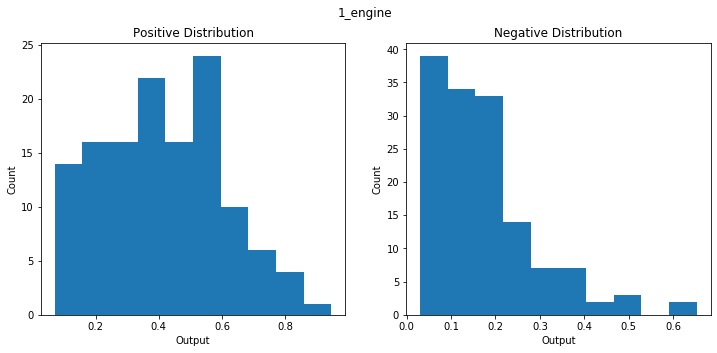

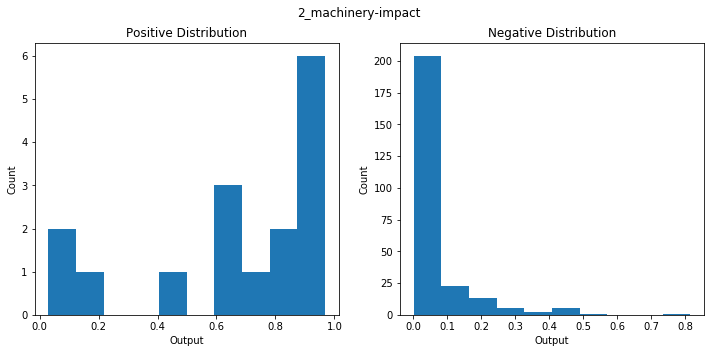

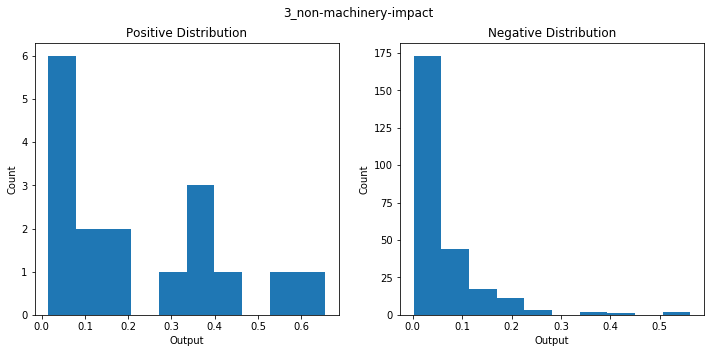

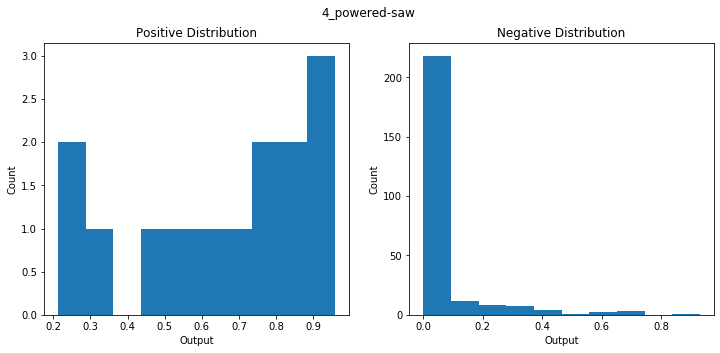

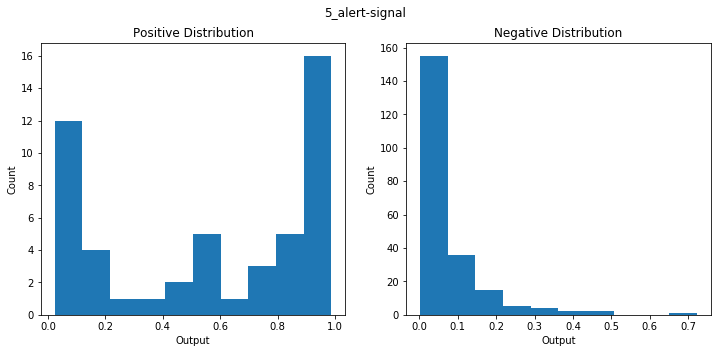

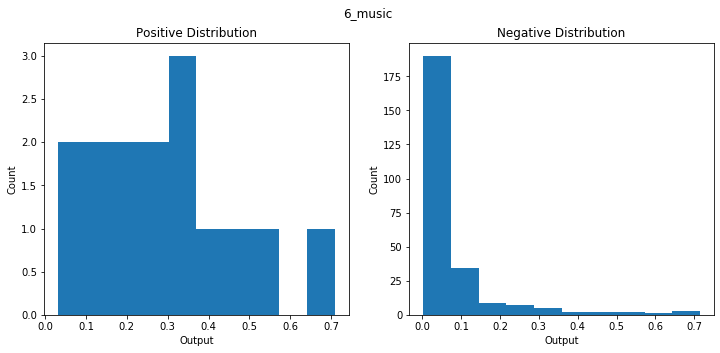

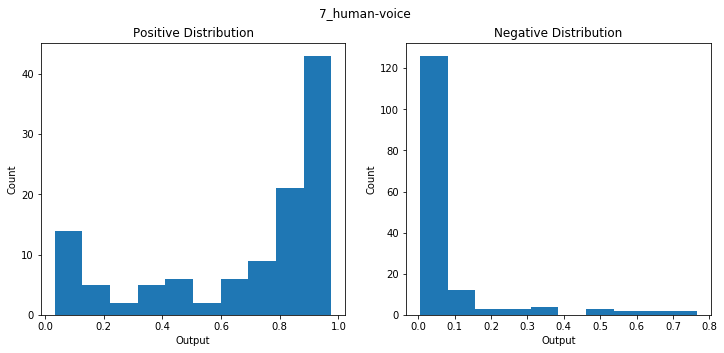

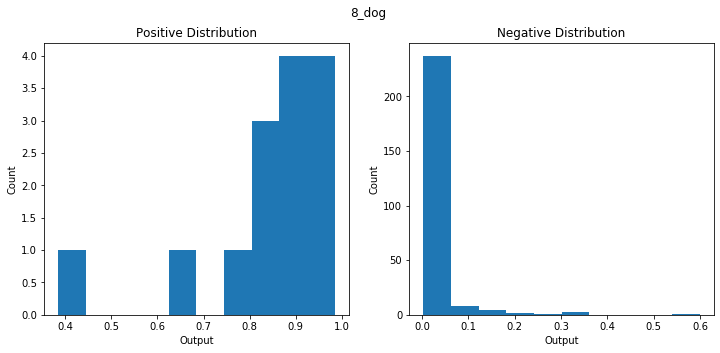

In [50]:
for label in coarse_target_labels:
    fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
    
    axes[0].hist(positive_dict[label])
    axes[0].set_xlabel('Output')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Positive Distribution')
    
    axes[1].hist(negative_dict[label])
    axes[1].set_xlabel('Output')
    axes[1].set_ylabel('Count')
    axes[1].set_title('Negative Distribution')
    fig.suptitle(label)